In [1]:
import pandas as pd
import numpy as np
import nrrd
import matplotlib.pyplot as plt


In [2]:
# file = './Brain_regions_t_types_composition.csv'
# df = pd.read_csv(file, index_col=0)

type_expr = pd.read_csv("./m_type_gene_expression_sum.csv", index_col=0)

file = './Brain_regions_me_types_composition.csv'
df = pd.read_csv(file, index_col=0, header=[0, 1])
# Combine the two levels of the MultiIndex into one
df.columns = [f"{col[0]}|{col[1]}" for col in df.columns]

file = './parcellation_to_parcellation_term_membership_extend.csv'
parcellation_annotation = pd.read_csv(file)

data_folder = "./warped_augmented_CCFv3/"
CCFv3a, _ = nrrd.read(f'{data_folder}annotation_25_2022_CCFv3a.nrrd')


In [16]:
# df = df.rename({x: " ".join(x.split("_")) for x in df.columns}, axis=1)
# type_expr = type_expr.rename({x: " ".join(x.split("_")) for x in type_expr.index}, axis=0)

In [17]:
# comon_types = df.columns.intersection(type_expr.index)

# df = df.reindex(comon_types, axis=1) @ type_expr.reindex(comon_types, axis=0)


In [3]:
ids = parcellation_annotation[parcellation_annotation['cluster_as_filename'].isin(df.index)][['label_numbers', 'cluster_as_filename']]

In [4]:
# Ensure matching data types (both should be strings)
df.index = df.index.astype(str)
ids['cluster_as_filename'] = ids['cluster_as_filename'].astype(str)

# Reset index to make df.index a column
df.reset_index(inplace=True)

# Merge based on df.index and ids.cluster_as_filename
merged_df = pd.merge(df, ids, left_on='index', right_on='cluster_as_filename')

# Optionally set the 'index' back as the index and clean up
merged_df.set_index('index', inplace=True)
merged_df.drop(columns='cluster_as_filename', inplace=True)

In [5]:
merged_df.head(3)
# merged_df.to_csv("predicted(sum)_ish_expression.csv")

,IN_dend_0_ax_0|bAC,IN_dend_0_ax_2|bAC,IN_dend_0_ax_3|bAC,IN_dend_0_ax_4|bAC,IN_dend_0_ax_5|bAC,IN_dend_0_ax_6|bAC,IN_dend_0_ax_8|bAC,IN_dend_0_ax_9|bAC,IN_dend_1_ax_0|bAC,IN_dend_1_ax_1|bAC,...,PC_dend_2_ax_8|dSTUT,PC_dend_3_ax_0|dSTUT,PC_dend_3_ax_4|dSTUT,PC_dend_3_ax_6|dSTUT,PC_dend_3_ax_7|dSTUT,PC_dend_3_ax_8|dSTUT,PC_dend_8_ax_4|dSTUT,PC_dend_8_ax_7|dSTUT,PC_dend_8_ax_8|dSTUT,label_numbers
index,,,,,,,,,,,,,,,,,,,,,
AId5,0.490255,0.0,111.467594,22.938932,11.728179,19.205543,27.564783,1.470764,3.888673,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1101
AId6a,2.483041,0.0,47.473315,41.476377,11.496801,30.706607,21.575971,7.449123,7.247700,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,783
AId6b,2.010751,0.0,16.293606,24.375447,0.000000,21.010783,23.478412,6.032252,37.930345,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,831


In [51]:
df.sum()[1:][df.sum()[1:] == max(df.sum()[1:])]
# df.sum()[1:]

PC_dend_1_ax_7|cADpyr    5369971.985445
dtype: object

In [52]:
%%time
# Replace all zeros in CCFv3a with np.nan
CCFv3a = np.where(CCFv3a == 0, np.nan, CCFv3a)

# Prepare the label mapping
me_type = 'PC_dend_1_ax_7|cADpyr'
label_numbers = merged_df['label_numbers'].values
cluster_values = merged_df[me_type].values
label_to_cluster = dict(zip(label_numbers, cluster_values))

# Define the worker function
def process_CCFv3a(CCFv3a, label_to_cluster, label_numbers):

    new_CCFv3a = np.full_like(CCFv3a, np.nan)

    for label in label_numbers:
        new_CCFv3a[CCFv3a == label] = label_to_cluster[label]
        
    # Retain existing np.nan values from the original CCFv3a
    nan_mask = np.isnan(CCFv3a)
    new_CCFv3a[nan_mask] = np.nan
    
    # Set 0 where values have not been populated
    new_CCFv3a[(~nan_mask) & (new_CCFv3a == np.nan)] = 0
    
    return new_CCFv3a


new_CCFv3a = process_CCFv3a(CCFv3a, label_to_cluster, label_numbers)

CPU times: user 2min 3s, sys: 4.12 s, total: 2min 7s
Wall time: 2min 8s


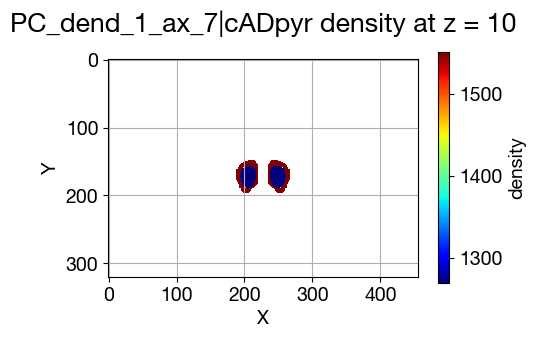

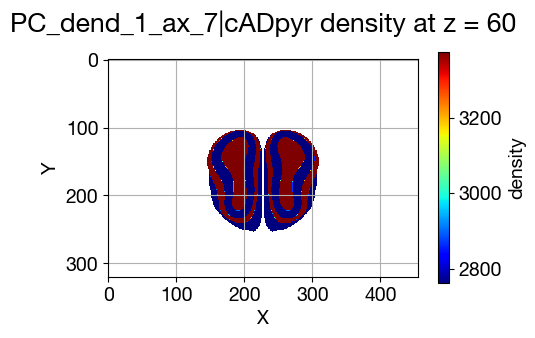

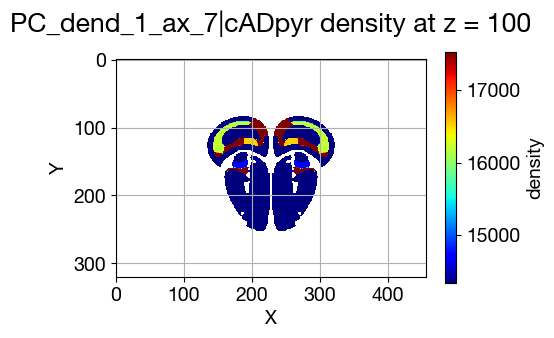

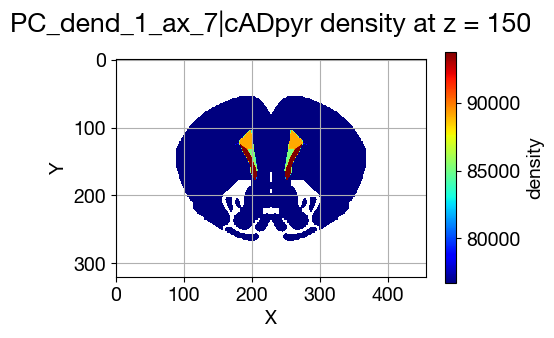

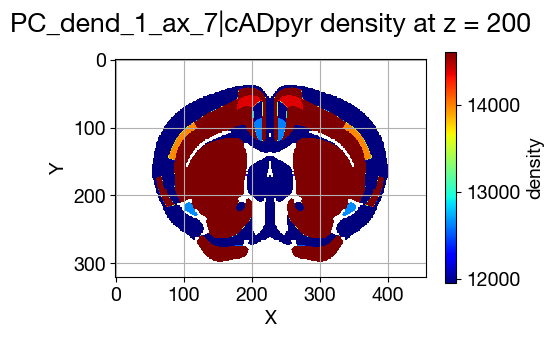

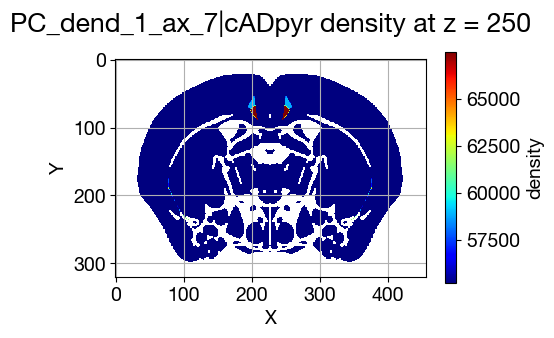

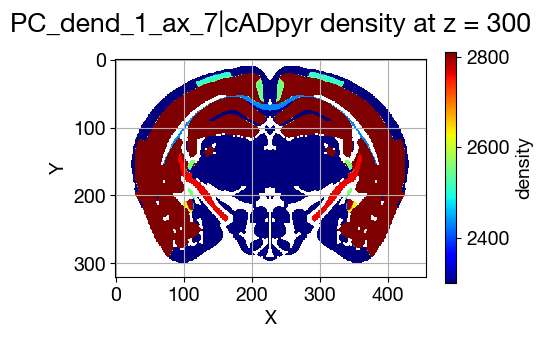

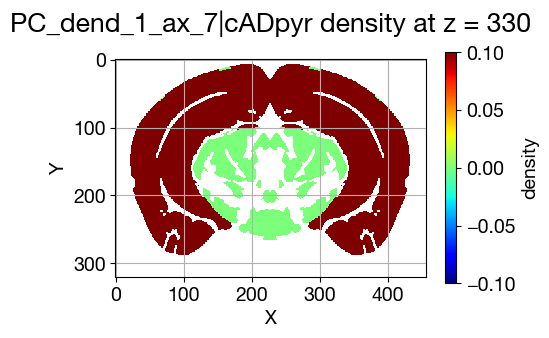

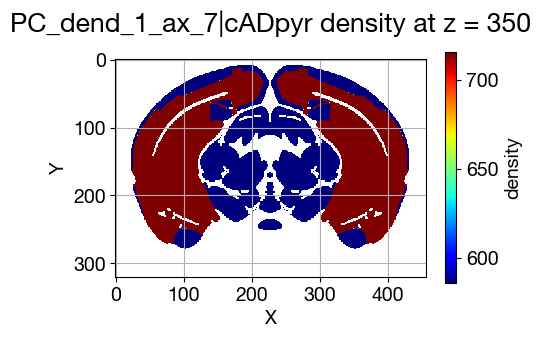

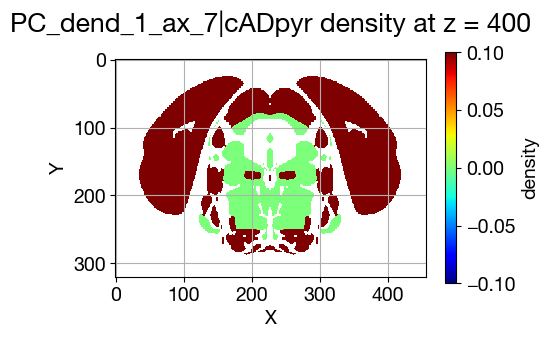

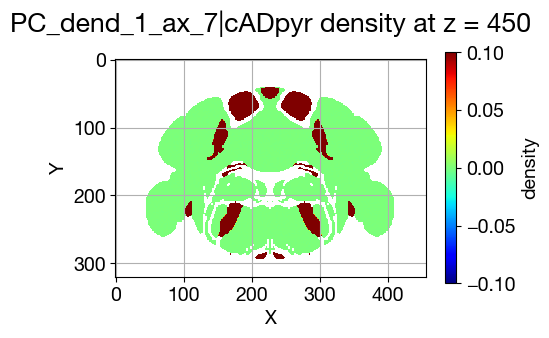

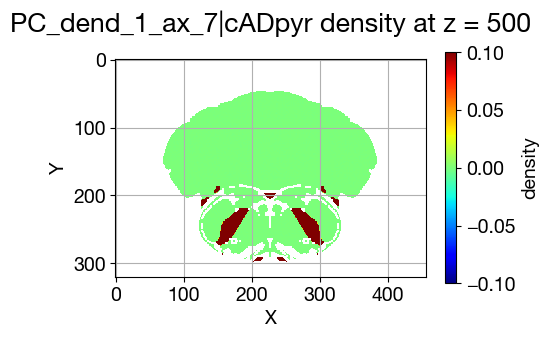

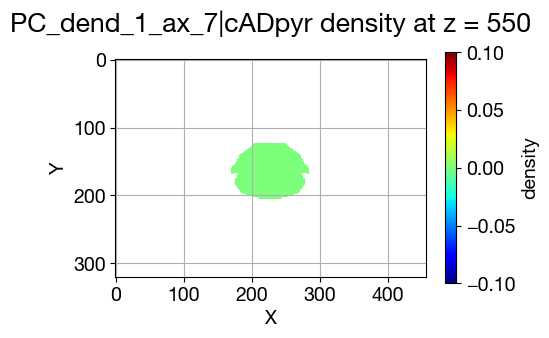

In [55]:
plt.rcParams.update({
    'font.size': 16,            # Default font size for text
    'font.family': 'Helvetica Neue',      # Font family (e.g., 'serif', 'sans-serif')
    'axes.titleweight': 'bold',  # Title font weight (e.g., 'bold', 'normal')
    'axes.labelsize': 14,        # Font size for axis labels
    'xtick.labelsize': 14,       # Font size for x-tick labels
    'ytick.labelsize': 14,       # Font size for y-tick labels
    'figure.titlesize': 16,      # Font size for figure title
    'figure.titleweight': 'bold',# Font weight for figure title
    'axes.titlepad': 20,         # Padding between title and plot
    'figure.figsize': (5, 3),   # Default figure size (width, height)
    'axes.titlelocation': 'center'  # Center-align the title
})

for z in [10, 60, 100, 150, 200, 250, 300, 330, 350, 400, 450, 500, 550]:
    plt.imshow(new_CCFv3a[z], vmin=np.min(cluster_values[z]), vmax=np.max(cluster_values[z]), cmap="jet");
    # Add a color bar
    plt.colorbar(label='density')
    # Define the coordinates
    x = np.nan
    y = np.nan
    
    # Create a scatter plot with a single point
    plt.scatter(y, x, color='red', label='Point')

    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'{me_type} density at z = {z}')
    
    # Show the plot
    # plt.legend()
    plt.grid(True)
    # plt.tight_layout()
    plt.show()


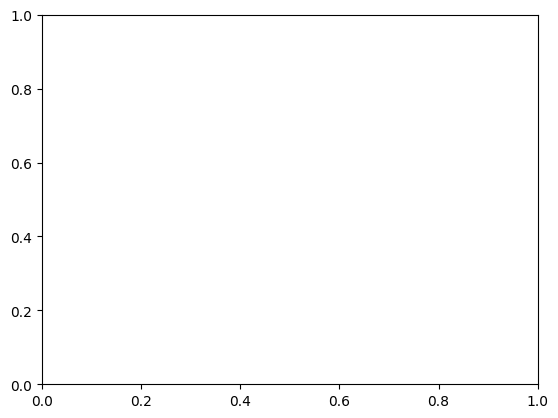

<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

# Define the z values
z_values = np.arange(1, len(new_CCFv3a), 10).tolist()

# Create a list that goes back and forth
z_values_full = z_values + z_values[::-1][1:-1]

fig, ax = plt.subplots()

def animate(i):
    z = z_values_full[i]
    ax.clear()
    im = ax.imshow(new_CCFv3a[z], vmin=np.min(cluster_values), vmax=np.max(cluster_values), cmap="jet")
    # Add a color bar
    if i == 0:
        plt.colorbar(im, ax=ax, label='cluster')
    # Define the coordinates
    x = np.nan
    y = np.nan

    # Create a scatter plot with a single point
    # ax.scatter(y, x, color='red', label='Point')

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Clusters of e-type composition at z = {z}')
    
    # Show the plot
    # ax.legend()
    ax.grid(True)

# Create the animation
ani = FuncAnimation(fig, animate, frames=len(z_values_full), interval=200, repeat=True)

# To display the animation in a Jupyter notebook
plt.show()

# To save the animation as a GIF
ani.save('animation.gif', writer='pillow')



In [10]:
parcellation_annotation

,Unnamed: 0,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label,label_numbers,cluster_as_filename
0,0,AllenCCF-Annotation-2020-997,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,987,3564320.0,3.56432,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN,997,brain
1,1,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-997,AllenCCF-Ontology-2017-ORGA,63,256520.0,0.25652,#FFFFFF,255,255,255,brain,brain,organ,0,0,NaN,68,brain
2,2,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-8,AllenCCF-Ontology-2017-CATE,63,256520.0,0.25652,#BFDAE3,191,218,227,Basic cell groups and regions,grey,category,1,1,AllenCCF-Ontology-2017-997,68,grey
3,3,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-315,AllenCCF-Ontology-2017-DIVI,63,256520.0,0.25652,#70FF71,112,255,113,Isocortex,Isocortex,division,2,1,AllenCCF-Ontology-2017-8,68,Isocortex
4,4,AllenCCF-Annotation-2020-68,AllenCCF-Ontology-2017-184,AllenCCF-Ontology-2017-STRU,63,256520.0,0.25652,#268F45,38,143,69,"Frontal pole, cerebral cortex",FRP,structure,3,1,AllenCCF-Ontology-2017-315,68,FRP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,3484,AllenCCF-Annotation-2020-10685,ABC-Ontology-COPY-substructure,AllenCCF-Ontology-2017-SUBS,1022,NaN,NaN,#FFFC91,255,252,145,"Copula pyramidis, Purkinje layer",COPYpurkinjelayer,substructure,4,746,AllenCCF-Ontology-2017-1049,10685,COPYpurkinjelayer
3485,3485,AllenCCF-Annotation-2020-10686,ABC-Ontology-2023-COPY-substructure,AllenCCF-Ontology-2017-SUBS,1022,NaN,NaN,#FFFC91,255,252,145,"Copula pyramidis, molecular layer",COPYmolecularlayer,substructure,4,746,AllenCCF-Ontology-2017-1049,10686,COPYmolecularlayer
3486,3486,AllenCCF-Annotation-2020-10720,AllenCCF-Ontology-2017-1091,AllenCCF-Ontology-2017-SUBS,1080,NaN,NaN,#FFFC91,255,252,145,"Lobules IV-V, granular layer",CUL45granularlayer,substructure,4,715,AllenCCF-Ontology-2017-1091,10720,CUL45granularlayer
3487,3487,AllenCCF-Annotation-2020-10721,AllenCCF-Ontology-2017-1091,AllenCCF-Ontology-2017-SUBS,1080,NaN,NaN,#FFFC91,255,252,145,"Lobules IV-V, Purkinje layer",CUL45purkinjelayer,substructure,4,715,AllenCCF-Ontology-2017-1091,10721,CUL45purkinjelayer


In [11]:
test = parcellation_annotation
test = test.set_index(parcellation_annotation["parcellation_term_acronym"]).drop(["Unnamed: 0"],axis=1)
test["parcellation_term_name"]

parcellation_term_acronym
brain                                              brain
brain                                              brain
grey                       Basic cell groups and regions
Isocortex                                      Isocortex
FRP                        Frontal pole, cerebral cortex
                                     ...                
COPYpurkinjelayer       Copula pyramidis, Purkinje layer
COPYmolecularlayer     Copula pyramidis, molecular layer
CUL45granularlayer          Lobules IV-V, granular layer
CUL45purkinjelayer          Lobules IV-V, Purkinje layer
CUL45molecularlayer        Lobules IV-V, molecular layer
Name: parcellation_term_name, Length: 3489, dtype: object

In [12]:
for x in merged_df.index:
    try:
        print(x, test["parcellation_term_name"][x])
    except:
        print(x, "nothing found")

AId5 Agranular insular area, dorsal part, layer 5
AId6a Agranular insular area, dorsal part, layer 6a
AId6b Agranular insular area, dorsal part, layer 6b
AIp5 Agranular insular area, posterior part, layer 5
AIp6a Agranular insular area, posterior part, layer 6a
AIv23 nothing found
AIv5 Agranular insular area, ventral part, layer 5
AIv6a Agranular insular area, ventral part, layer 6a
AIv6b Agranular insular area, ventral part, layer 6b
AON parcellation_term_acronym
AON    Anterior olfactory nucleus
AON    Anterior olfactory nucleus
Name: parcellation_term_name, dtype: object
AON parcellation_term_acronym
AON    Anterior olfactory nucleus
AON    Anterior olfactory nucleus
Name: parcellation_term_name, dtype: object
AUDd6a Dorsal auditory area, layer 6a
AUDd6b Dorsal auditory area, layer 6b
AUDp5 Primary auditory area, layer 5
AUDp6a Primary auditory area, layer 6a
AUDp6b Primary auditory area, layer 6b
AUDv5 Ventral auditory area, layer 5
AUDv6a Ventral auditory area, layer 6a
AUDv6b Ven

In [13]:
test[["OB" in x for x in test.index]]["label_numbers"]

parcellation_term_acronym
MOB                   507
MOB                   220
MOBgr                 220
MOB                   228
MOBipl                228
MOB                   236
MOBmi                 236
MOB                   244
MOBopl                244
AOB                   188
AOBgl                 188
AOB                   196
AOBgr                 196
AOB                   204
AOBmi                 204
MOB-unassigned        507
MOBglomerularlayer    212
Name: label_numbers, dtype: int64

In [133]:
test[test["label_numbers"].values==236]["parcellation_term_name"]

parcellation_term_acronym
brain                                brain
grey         Basic cell groups and regions
OLF                        Olfactory areas
MOB                    Main olfactory bulb
MOBmi    Main olfactory bulb, mitral layer
Name: parcellation_term_name, dtype: object

In [132]:
np.sum(merged_df.T["MOBmi"].T[:-3])

231.29158606509415

In [15]:
test[["OB" in x for x in test.index]]["parcellation_term_name"]

parcellation_term_acronym
MOB                                          Main olfactory bulb
MOB                                          Main olfactory bulb
MOBgr                         Main olfactory bulb, granule layer
MOB                                          Main olfactory bulb
MOBipl                Main olfactory bulb, inner plexiform layer
MOB                                          Main olfactory bulb
MOBmi                          Main olfactory bulb, mitral layer
MOB                                          Main olfactory bulb
MOBopl                Main olfactory bulb, outer plexiform layer
AOB                                     Accessory olfactory bulb
AOBgl                 Accessory olfactory bulb, glomerular layer
AOB                                     Accessory olfactory bulb
AOBgr                   Accessory olfactory bulb, granular layer
AOB                                     Accessory olfactory bulb
AOBmi                     Accessory olfactory bulb, mitral layer

In [29]:
test[["lfactory" in x for x in test["parcellation_term_name"]]]

,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label,label_numbers,cluster_as_filename
parcellation_term_acronym,,,,,,,,,,,,,,,,,,
OLF,AllenCCF-Annotation-2020-698,AllenCCF-Ontology-2017-698,AllenCCF-Ontology-2017-DIVI,688,5018622.0,5.018622,#9AD2BD,154,210,189,Olfactory areas,OLF,division,2,2,AllenCCF-Ontology-2017-8,698,OLF
OLF,AllenCCF-Annotation-2020-507,AllenCCF-Ontology-2017-698,AllenCCF-Ontology-2017-DIVI,497,4298904.0,4.298904,#9AD2BD,154,210,189,Olfactory areas,OLF,division,2,2,AllenCCF-Ontology-2017-8,507,OLF
MOB,AllenCCF-Annotation-2020-507,AllenCCF-Ontology-2017-507,AllenCCF-Ontology-2017-STRU,497,4298904.0,4.298904,#9AD2BD,154,210,189,Main olfactory bulb,MOB,structure,3,45,AllenCCF-Ontology-2017-698,507,MOB
OLF,AllenCCF-Annotation-2020-220,AllenCCF-Ontology-2017-698,AllenCCF-Ontology-2017-DIVI,213,5183936.0,5.183936,#9AD2BD,154,210,189,Olfactory areas,OLF,division,2,2,AllenCCF-Ontology-2017-8,220,OLF
MOB,AllenCCF-Annotation-2020-220,AllenCCF-Ontology-2017-507,AllenCCF-Ontology-2017-STRU,213,5183936.0,5.183936,#9AD2BD,154,210,189,Main olfactory bulb,MOB,structure,3,45,AllenCCF-Ontology-2017-698,220,MOB
MOBgr,AllenCCF-Annotation-2020-220,AllenCCF-Ontology-2017-220,AllenCCF-Ontology-2017-SUBS,213,5183936.0,5.183936,#82C7AE,130,199,174,"Main olfactory bulb, granule layer",MOBgr,substructure,4,254,AllenCCF-Ontology-2017-507,220,MOBgr
OLF,AllenCCF-Annotation-2020-228,AllenCCF-Ontology-2017-698,AllenCCF-Ontology-2017-DIVI,221,1036894.0,1.036894,#9AD2BD,154,210,189,Olfactory areas,OLF,division,2,2,AllenCCF-Ontology-2017-8,228,OLF
MOB,AllenCCF-Annotation-2020-228,AllenCCF-Ontology-2017-507,AllenCCF-Ontology-2017-STRU,221,1036894.0,1.036894,#9AD2BD,154,210,189,Main olfactory bulb,MOB,structure,3,45,AllenCCF-Ontology-2017-698,228,MOB
MOBipl,AllenCCF-Annotation-2020-228,AllenCCF-Ontology-2017-228,AllenCCF-Ontology-2017-SUBS,221,1036894.0,1.036894,#9AD2BD,154,210,189,"Main olfactory bulb, inner plexiform layer",MOBipl,substructure,4,255,AllenCCF-Ontology-2017-507,228,MOBipl


In [28]:
test[[("triatum" in x) for x in test["parcellation_term_name"]]]

,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label,label_numbers,cluster_as_filename
parcellation_term_acronym,,,,,,,,,,,,,,,,,,
STR,AllenCCF-Annotation-2020-477,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,467,2677822.0,2.677822,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,477,STR
STR,AllenCCF-Annotation-2020-672,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,662,26018770.0,26.018770,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,672,STR
STR,AllenCCF-Annotation-2020-56,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,51,4401366.0,4.401366,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,56,STR
STR,AllenCCF-Annotation-2020-998,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,988,428468.0,0.428468,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,998,STR
FS,AllenCCF-Annotation-2020-998,AllenCCF-Ontology-2017-998,AllenCCF-Ontology-2017-STRU,988,428468.0,0.428468,#80CDF8,128,205,248,Fundus of striatum,FS,structure,3,83,AllenCCF-Ontology-2017-477,998,FS
STR,AllenCCF-Annotation-2020-754,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,744,3823686.0,3.823686,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,754,STR
STR,AllenCCF-Annotation-2020-250,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,243,563601.0,0.563601,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,250,STR
STR,AllenCCF-Annotation-2020-258,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,251,1881915.0,1.881915,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,258,STR
STR,AllenCCF-Annotation-2020-266,AllenCCF-Ontology-2017-477,AllenCCF-Ontology-2017-DIVI,258,607236.0,0.607236,#98D6F9,152,214,249,Striatum,STR,division,2,5,AllenCCF-Ontology-2017-8,266,STR


In [27]:
test[[("bellum" in x) for x in test["parcellation_term_name"]]]

,parcellation_label,parcellation_term_label,parcellation_term_set_label,parcellation_index,voxel_count,volume_mm3,color_hex_triplet,red,green,blue,parcellation_term_name,parcellation_term_acronym,parcellation_term_set_name,term_set_order,term_order,parent_term_label,label_numbers,cluster_as_filename
parcellation_term_acronym,,,,,,,,,,,,,,,,,,
CB,AllenCCF-Annotation-2020-512,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,502,829262.0,0.829262,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,512,CB
CB,AllenCCF-Annotation-2020-912,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,902,121628.0,0.121628,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,912,CB
CB,AllenCCF-Annotation-2020-976,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,966,1335660.0,1.335660,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,976,CB
CB,AllenCCF-Annotation-2020-984,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,974,2743760.0,2.743760,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,984,CB
CB,AllenCCF-Annotation-2020-1091,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,1080,6725776.0,6.725776,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,1091,CB
CB,AllenCCF-Annotation-2020-936,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,926,3334748.0,3.334748,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,936,CB
CB,AllenCCF-Annotation-2020-944,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,934,1053398.0,1.053398,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,944,CB
CB,AllenCCF-Annotation-2020-951,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,941,1248018.0,1.248018,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,951,CB
CB,AllenCCF-Annotation-2020-957,AllenCCF-Ontology-2017-512,AllenCCF-Ontology-2017-DIVI,947,2191534.0,2.191534,#F0F080,240,240,128,Cerebellum,CB,division,2,12,AllenCCF-Ontology-2017-8,957,CB


In [26]:
test[[("thalamus" in x) for x in test["parcellation_term_name"]]]["parcellation_term_name"]

parcellation_term_acronym
VAL               Ventral anterior-lateral complex of the thalamus
VM                          Ventral medial nucleus of the thalamus
VPL                 Ventral posterolateral nucleus of the thalamus
VPLpc            Ventral posterolateral nucleus of the thalamus...
VPM                  Ventral posteromedial nucleus of the thalamus
                                       ...                        
CL                         Central lateral nucleus of the thalamus
RT                               Reticular nucleus of the thalamus
HY-unassigned                             Hypothalamus, unassigned
HY-unassigned                             Hypothalamus, unassigned
DMH                        Dorsomedial nucleus of the hypothalamus
Name: parcellation_term_name, Length: 109, dtype: object